
# xmolout\_analyzer — End‑to‑End Test Notebook

This notebook mirrors your test driver script and breaks it into runnable cells.

**What it does**  
1) Get box dimensions  
2) Plot trajectory of atom 0 across all frames & save CSV  
3) Compute MSD for atom 0  
4) Get atom types in frame 0  
5) Compute RDF (OVITO) for frame 0  
6) Compute RDF properties (area, first_peak, dominant_peak) over all frames  

> **Note:** This notebook expects your `reaxkit` package (with `XmoloutHandler`, `rdf_using_ovito`, etc.) to be importable in the environment. OVITO is optional; RDF steps will be skipped with a message if OVITO isn't available.


In [5]:

# Setup & imports
from __future__ import annotations
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reaxkit imports (must be available in your environment)
from reaxkit.io.xmolout_handler import XmoloutHandler
from reaxkit.analysis.RDF_analyzer import (
    rdf_property_over_frames,
    rdf_using_ovito,
)
from reaxkit.analysis.xmolout_analyzer import (
    get_box_dimensions,
    get_atom_trajectories,
    mean_squared_displacement,
    get_atom_type_mapping,
)

# Matplotlib inline display
%matplotlib inline


In [7]:

# Configure paths
XMOL_PATH = 'xmolout'          # <-- change if your file has a different name/path
OUTDIR    = 'xma_test_outputs' # <-- change if you want a different output dir

def ensure_outdir(p: str | Path) -> Path:
    out = Path(p).expanduser().resolve()
    out.mkdir(parents=True, exist_ok=True)
    return out

outdir = ensure_outdir(OUTDIR)

In [8]:

# Load xmolout
print(f"[0] Loading xmolout: {XMOL_PATH}")
xh = XmoloutHandler(XMOL_PATH)
print("Loaded.")


[0] Loading xmolout: xmolout
Loaded.


## 1) Get box dimensions

In [10]:

print("[1] Getting box dimensions…")
df_box = get_box_dimensions(xh)
display(df_box.head())

csv_path = Path(outdir) / "box_dimensions.csv"
df_box.to_csv(csv_path, index=False)
print(f"saved")


[1] Getting box dimensions…


,frame_index,iter,a,b,c,alpha,beta,gamma,E_pot,num_of_atoms
0,0,0,11.03,12.73,100.0,90.0,90.0,90.0,-43754.80,276
1,1,25,11.03,12.73,100.0,90.0,90.0,90.0,-43745.87,276
2,2,50,11.03,12.73,100.0,90.0,90.0,90.0,-43735.18,276
3,3,75,11.03,12.73,100.0,90.0,90.0,90.0,-43758.58,276
4,4,100,11.03,12.73,100.0,90.0,90.0,90.0,-43787.60,276


saved


## 2) Trajectory for atom 0 across all frames & plot

[2] Trajectory for atom 0 across all frames…


,frame_index,iter,atom_id,atom_type,x,y,z
0,0,0,1,N,0.91321,5.57685,41.34705
1,1,25,1,N,0.95609,5.55383,41.37000
2,2,50,1,N,0.99849,5.53184,41.41128
3,3,75,1,N,1.02600,5.51367,41.46853
4,4,100,1,N,1.03263,5.50292,41.52898


saved


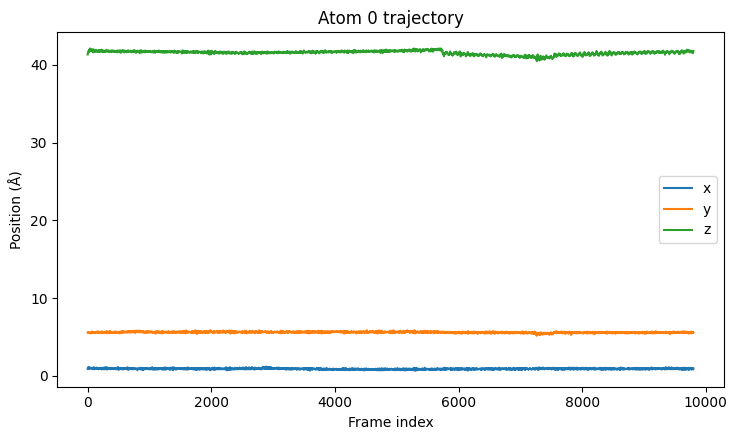

saved


In [12]:

print("[2] Trajectory for atom 0 across all frames…")
traj = get_atom_trajectories(xh, atoms=[0], dims=("x", "y", "z"), format="long")
display(traj.head())

csv_path = Path(outdir) / "traj_atom0.csv"
traj.to_csv(csv_path, index=False)
print(f"saved")

# Plot x,y,z vs frame_index
fig = plt.figure(figsize=(7.5, 4.5))
for col in ("x", "y", "z"):
    if col in traj.columns:
        plt.plot(traj["frame_index"], traj[col], label=col)
plt.xlabel("Frame index")
plt.ylabel("Position (Å)")
plt.title("Atom 0 trajectory")
plt.legend()
plt.tight_layout()
png_path = Path(outdir) / "traj_atom0.png"
fig.savefig(png_path, dpi=160)
plt.show()
print(f"saved")


## 3) Mean Squared Displacement (MSD) for atom 0

[3] MSD for atom 0…


,frame_index,msd
0,0,0.000000
1,1,0.036586
2,2,0.165380
3,3,0.353373
4,4,0.731154


saved


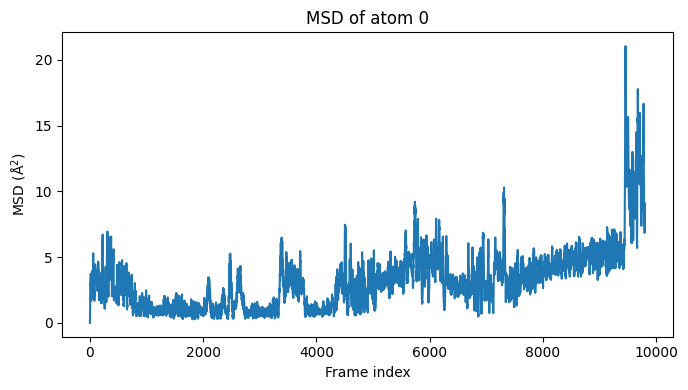

saved


In [13]:

print("[3] MSD for atom 0…")
msd_vals = mean_squared_displacement(xh, atoms=[0])

# Normalize to tidy DataFrame with columns: frame_index, msd
if isinstance(msd_vals, pd.DataFrame):
    df_tmp = msd_vals.copy()
    if "msd" in df_tmp.columns:
        msd_col = "msd"
    elif "value" in df_tmp.columns:
        msd_col = "value"
    else:
        raise KeyError("MSD result DataFrame must have a 'msd' (or 'value') column.")

    if "frame" in df_tmp.columns:
        frame_col = "frame"
    elif "frame_index" in df_tmp.columns:
        frame_col = "frame_index"
    else:
        df_tmp = df_tmp.reset_index().rename(columns={"index": "frame_index"})
        frame_col = "frame_index"

    for atom_col in ("atom", "atom_id", "aid"):
        if atom_col in df_tmp.columns:
            df_tmp = df_tmp[df_tmp[atom_col] == 1]  # 1-based just in case

    df_msd = df_tmp[[frame_col, msd_col]].rename(columns={frame_col: "frame_index", msd_col: "msd"})
    df_msd = df_msd.sort_values("frame_index").reset_index(drop=True)
else:
    msd_arr = np.asarray(msd_vals)
    df_msd = pd.DataFrame({"frame_index": np.arange(msd_arr.shape[0]), "msd": msd_arr})

# Join iteration safely if available
df_sim = xh.dataframe().reset_index(drop=True)
if "iteration" in df_sim.columns:
    df_sim = df_sim.reset_index().rename(columns={"index": "frame_index"})
    df_msd = df_msd.merge(df_sim[["frame_index", "iteration"]], on="frame_index", how="left")

display(df_msd.head())

csv_path = Path(outdir) / "msd_atom0.csv"
png_path = Path(outdir) / "msd_atom0.png"
df_msd.to_csv(csv_path, index=False)
print(f"saved")

fig = plt.figure(figsize=(7.0, 4.0))
plt.plot(df_msd["frame_index"], df_msd["msd"])
plt.xlabel("Frame index")
plt.ylabel("MSD (Å$^2$)")
plt.title("MSD of atom 0")
plt.tight_layout()
fig.savefig(png_path, dpi=160)
plt.show()
print(f"saved")


## 4) Atom types in frame 0

In [14]:

print("[4] Atom types in frame 0…")
mapping = get_atom_type_mapping(xh, frame=0)
print(mapping)
json_path = Path(outdir) / "atom_types_frame0.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(mapping, f, indent=2)
print(f"saved")


[4] Atom types in frame 0…
{'types': ['Al', 'H', 'N', 'O'], 'type_to_indices': {'Al': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256], 'H': [258, 260, 262, 264, 266, 268, 270, 272, 274, 276], 'N': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 11

## 5) RDF (OVITO) for frame 0

[5] RDF (OVITO) for frame 0…


,r,g
0,0.010417,0.0
1,0.031250,0.0
2,0.052083,0.0
3,0.072917,0.0
4,0.093750,0.0


saved


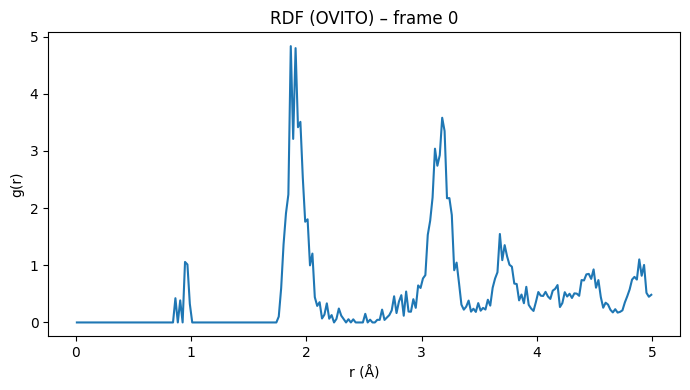

saved


In [16]:

print("[5] RDF (OVITO) for frame 0…")
try:
    r, g = rdf_using_ovito(
        xh,
        frames=[0],
        r_max=5.0,
        bins=240,
        types_a=None,
        types_b=None,
        average=False,
    )
    df_rg = pd.DataFrame({"r": r, "g": g})
    display(df_rg.head())

    csv_path = Path(outdir) / "rdf_frame0_ovito.csv"
    png_path = Path(outdir) / "rdf_frame0_ovito.png"
    df_rg.to_csv(csv_path, index=False)
    print(f"saved")

    fig = plt.figure(figsize=(7.0, 4.0))
    plt.plot(df_rg["r"], df_rg["g"])
    plt.xlabel("r (Å)")
    plt.ylabel("g(r)")
    plt.title("RDF (OVITO) – frame 0")
    plt.tight_layout()
    fig.savefig(png_path, dpi=160)
    plt.show()
    print(f"saved")
except Exception as e:
    print("! OVITO RDF failed (is ovito installed and importable via reaxkit?):", e)


## 6) RDF properties (area, first_peak, dominant_peak) over frames

[6] RDF properties for frames…


,frame_index,iter,area,first_coordination,g_first_peak,dominant_coordination,g_peak
0,0,0,2.486216,0.864583,0.424015,1.864583,4.831963
1,1,25,2.466775,0.864583,1.674732,1.906250,4.478777
2,2,50,2.508875,0.864583,0.427237,1.927083,4.041997
3,3,75,2.554552,0.885417,1.650464,1.864583,4.187027
4,4,100,2.604534,0.885417,0.420633,1.885417,4.823955


saved


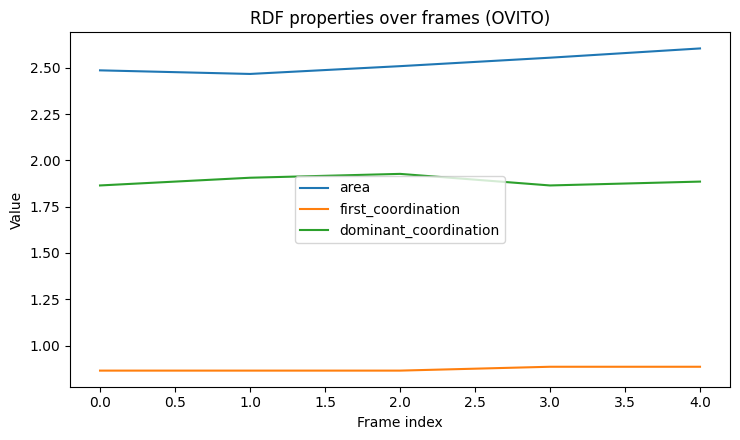

saved


In [17]:

print("[6] RDF properties for frames…")
try:
    # You can change the frame window here
    n_frames = len(xh.dataframe())
    frames = range(0, min(n_frames, 5), 1)

    df_area  = rdf_property_over_frames(xh, frames=frames, r_max=5.0, bins=240, property="area")
    df_first = rdf_property_over_frames(xh, frames=frames, r_max=5.0, bins=240, property="first_peak")
    df_dom   = rdf_property_over_frames(xh, frames=frames, r_max=5.0, bins=240, property="dominant_peak")

    # Normalize column names for a tidy merge
    df_area  = df_area.rename(columns={"area": "area"})
    df_first = df_first.rename(columns={"r_first_peak": "first_coordination"})
    df_dom   = df_dom.rename(columns={"r_peak": "dominant_coordination"})

    merged = (
        df_area.merge(df_first, on=["frame_index", "iter"], how="outer")
               .merge(df_dom,   on=["frame_index", "iter"], how="outer")
               .sort_values("frame_index")
               .reset_index(drop=True)
    )
    display(merged.head())

    csv_path = Path(outdir) / "rdf_props_summary.csv"
    png_path = Path(outdir) / "rdf_props_summary.png"
    merged.to_csv(csv_path, index=False)
    print(f"saved")

    fig = plt.figure(figsize=(7.5, 4.5))
    for col in ("area", "first_coordination", "dominant_coordination"):
        if col in merged.columns:
            plt.plot(merged["frame_index"], merged[col], label=col)
    plt.xlabel("Frame index")
    plt.ylabel("Value")
    plt.title("RDF properties over frames (OVITO)")
    plt.legend()
    plt.tight_layout()
    fig.savefig(png_path, dpi=160)
    plt.show()
    print(f"saved")
except Exception as e:
    print("! RDF properties failed:", e)



---

**Done.** Adjust `XMOL_PATH`, `OUTDIR`, or the frame ranges and re-run cells as needed.
